In [33]:
import numpy as np
from scipy import stats
from collections import namedtuple
from tqdm import tqdm
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot') #graphics style

In [34]:
# asymptotic z-test (CLT)
ExperimentResults = namedtuple('ExperimentResults', 
                                        ['effect', 'left', 'right', 'ci_len', 'pval'])
def z_test(control, test):
    mean_c, mean_t = np.mean(control), np.mean(test)
    var_c, var_t = np.var(control), np.var(test)
    l_c, l_t = len(control), len(test)
    
    d = stats.norm(
            loc = mean_t - mean_c, 
            scale = np.sqrt(var_c / l_c + var_t / l_t))
    
    effect = mean_t - mean_c
    left, right = d.ppf([0.025, 0.975])    #ppf — квантиль распределения
    ci_len = right - left
    pval = 2 * min(d.cdf(0), 1 - d.cdf(0))    #cdf — функция распределения
    
    return(ExperimentResults(effect, left, right, ci_len, pval))

In [35]:
# cuped test without mean(covariate) shift 
def pure_cuped_test(control, test, control_before, test_before):
    
    theta = (np.cov(control, control_before)[0,1] + np.cov(test, test_before)[0,1]) / (np.var(control_before) + np.var(test_before))
    control_cuped = control - theta * control_before
    test_cuped = test - theta * test_before
    
    return z_test(control_cuped, test_cuped)

In [36]:
# cuped test with mean(covariate) shift
def booking_cuped_test(control, test, control_before, test_before):
    
    theta = (np.cov(control, control_before)[0,1] + np.cov(test, test_before)[0,1]) / (np.var(control_before) + np.var(test_before))
    
    control_before_mean, test_before_mean = np.mean(control_before), np.mean(test_before)
    control_cuped = control - theta * (control_before - control_before_mean)
    test_cuped = test - theta * (test_before - test_before_mean)
    
    return z_test(control_cuped, test_cuped)

In [41]:
# Now we simulate A/A-test and check if type I error equals 5%

bad_cnt, bad_cnt_pure_cuped, bad_cnt_booking_cuped = 0,0,0 # here we count if test incorrectly rejected the hypothesis H_0
pval_arr, pval_arr_pure_cuped, pval_arr_booking_cuped = [], [], []
N = 10**4  #number of simulations
sample_len = 10000  #length of sample

for i in tqdm(range(N)):
    
    # simulate control and test AA samples and simulate previous data for them 
    control_before = stats.expon(scale = 100).rvs(sample_len)
    control = control_before + stats.norm(loc=0, scale=10).rvs(sample_len)
    test_before = stats.expon(scale = 100).rvs(sample_len)
    test = test_before + stats.norm(loc=0, scale=10).rvs(sample_len)
    
    # find p-value for each test 
    _,_,_,_,p = z_test(control, test)
    _,_,_,_,p_pc = pure_cuped_test(control, test, control_before, test_before)
    _,_,_,_,p_bc = booking_cuped_test(control, test, control_before, test_before)
    pval_arr.append(p)
    pval_arr_pure_cuped.append(p_pc)
    pval_arr_booking_cuped.append(p_bc)
    
    # if test incorrectly rejected the hypothesis add to bad count
    if p < 0.05:
        bad_cnt += 1
    if p_pc < 0.05:
        bad_cnt_pure_cuped += 1
    if p_bc < 0.05:
        bad_cnt_booking_cuped += 1

# find confidence intervals for type I error of our tests (5% should be in CI)
l_t, r_t = proportion_confint(count = bad_cnt, nobs = N, alpha=0.05, method='wilson')
print(f"Asymptotic z-test: {bad_cnt} mistakes among {N} test ({100 * bad_cnt / N}%)." 
      f" CI for type I error: [{round(100 * l_t, 2)}%, {round(100 * r_t, 2)}%].")

l_t, r_t = proportion_confint(count = bad_cnt_pure_cuped, nobs = N, alpha=0.05, method='wilson')
print(f"Pure CUPED test: {bad_cnt_pure_cuped} mistakes among {N} test ({100 * bad_cnt_pure_cuped / N}%)." 
      f" CI for type I error: [{round(100 * l_t, 2)}%, {round(100 * r_t, 2)}%].")

l_t, r_t = proportion_confint(count = bad_cnt_booking_cuped, nobs = N, alpha=0.05, method='wilson')
print(f"Booking CUPED test: {bad_cnt_booking_cuped} mistakes among {N} test ({100 * bad_cnt_booking_cuped / N}%)." 
      f" CI for type I error: [{round(100 * l_t, 2)}%, {round(100 * r_t, 2)}%].")

100%|████████████████████████████████████| 10000/10000 [00:51<00:00, 194.65it/s]

Asymptotic z-test: 521 mistakes among 10000 test (5.21%). CI for type I error: [4.79%, 5.66%].
Pure CUPED test: 496 mistakes among 10000 test (4.96%). CI for type I error: [4.55%, 5.4%].
Booking CUPED test: 8383 mistakes among 10000 test (83.83%). CI for type I error: [83.1%, 84.54%].


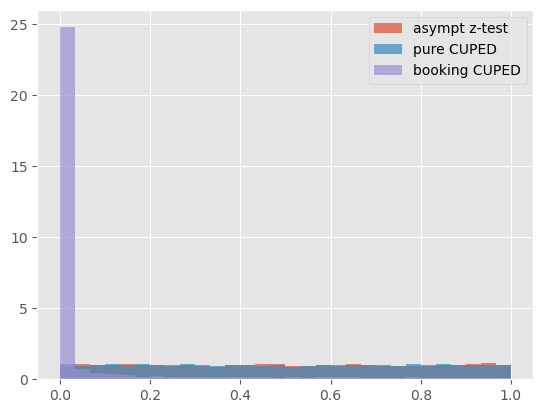

In [42]:
plt.hist(pval_arr, bins=30, alpha=0.7, density=True, label = 'asympt z-test')
plt.hist(pval_arr_pure_cuped, bins=30, alpha=0.7, density=True, label = 'pure CUPED')
plt.hist(pval_arr_booking_cuped, bins=30, alpha=0.7, density=True, label = 'booking CUPED')
plt.legend(loc='upper right')
plt.show()
# pvalue distribution is not uniform for CUPED with shift